Episode 50/500 -- Total Reward: 12.50
Episode 100/500 -- Total Reward: 13.64
Episode 150/500 -- Total Reward: 19.47
Episode 200/500 -- Total Reward: 18.71
Episode 250/500 -- Total Reward: 19.10
Episode 300/500 -- Total Reward: 23.68
Episode 350/500 -- Total Reward: 24.18
Episode 400/500 -- Total Reward: 25.13
Episode 450/500 -- Total Reward: 23.90
Episode 500/500 -- Total Reward: 22.60
✅ Model saved to ppo_trading_model_vz.pt


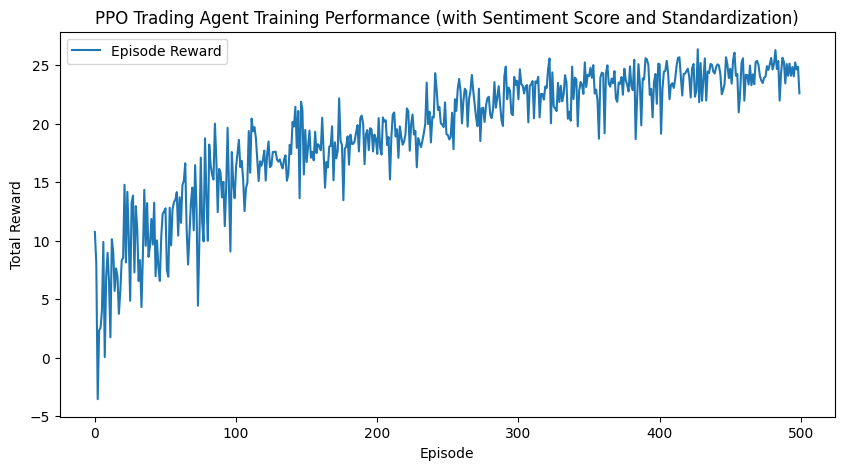

Step: 0, Price: 37.70, Balance: 10000.00, Shares: 0, Equity: 10000.00, Position: 0
Step: 1, Price: 38.88, Balance: 9961.12, Shares: 1, Equity: 10000.00, Position: 1
Step: 2, Price: 39.16, Balance: 9961.12, Shares: 1, Equity: 10000.28, Position: 1
Step: 3, Price: 39.37, Balance: 9961.12, Shares: 1, Equity: 10000.49, Position: 1
Step: 4, Price: 40.20, Balance: 9961.12, Shares: 1, Equity: 10001.32, Position: 1
Step: 5, Price: 40.10, Balance: 9961.12, Shares: 1, Equity: 10001.22, Position: 1
Step: 6, Price: 39.04, Balance: 9961.12, Shares: 1, Equity: 10000.16, Position: 1
Step: 7, Price: 39.08, Balance: 9961.12, Shares: 1, Equity: 10000.20, Position: 1
Step: 8, Price: 37.90, Balance: 9961.12, Shares: 1, Equity: 9999.02, Position: 1
Step: 9, Price: 38.56, Balance: 9961.12, Shares: 1, Equity: 9999.68, Position: 1
Step: 10, Price: 39.29, Balance: 9961.12, Shares: 1, Equity: 10000.41, Position: 1
Step: 11, Price: 38.87, Balance: 9961.12, Shares: 1, Equity: 9999.99, Position: 1
Step: 12, Price:

In [30]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from gym import spaces

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# =============================================================================
# 1. Trading Environment Including Standardization and Sentiment Score
# =============================================================================
class TradingEnv(gym.Env):
    """
    A custom trading environment that now includes a sentiment score and standardizes
    technical indicator features.
    The CSV is expected to have the following columns:
      - "Price": current stock price.
      - "MA5": 5-day moving average.
      - "MA20": 20-day moving average.
      - "RSI": Relative Strength Index.
      - "MACD": Moving Average Convergence Divergence.
      - "sentiment_score": numerical sentiment score.
      
    The state is defined as a vector:
      [standardized Price, MA5, MA20, RSI, MACD, sentiment_score, Position],
    where Position is 1 if holding a share and 0 if not.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, data_path="/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/Merged_Data_For_RL/VZ_stock_data_2022-01-01_to_2024-12-31.csv",
                 initial_balance=10000, stop_loss_multiplier=2, window=5):
        super(TradingEnv, self).__init__()
        self.data_path = data_path
        self.initial_balance = initial_balance
        self.stop_loss_multiplier = stop_loss_multiplier
        self.window = window
        
        # Load preprocessed data into a DataFrame.
        self.data = pd.read_csv(self.data_path)
        self.num_data = len(self.data)
        
        # Compute the mean and standard deviation for standardization.
        feature_cols = ["Price", "MA5", "MA20", "RSI", "MACD", "sentiment_score"]
        self.feature_mean = self.data[feature_cols].mean()
        self.feature_std = self.data[feature_cols].std()
        
        # Define actions: 0 = Hold, 1 = Buy, 2 = Sell.
        self.action_space = spaces.Discrete(3)
        # Updated observation: [standardized Price, MA5, MA20, RSI, MACD, sentiment_score, Position]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)
        
        self.reset()

    def _get_state(self):
        """Return the standardized state from the current timestep."""
        row = self.data.iloc[self.current_step]
        # Standardize each numerical feature.
        standardized_features = []
        for col in ["Price", "MA5", "MA20", "RSI", "MACD", "sentiment_score"]:
            standardized = (row[col] - self.feature_mean[col]) / self.feature_std[col]
            standardized_features.append(standardized)
        # Append the Position without scaling.
        standardized_features.append(self.position)
        state = np.array(standardized_features, dtype=np.float32)
        return state

    def reset(self):
        """
        Resets the environment:
          - Sets cash balance to initial_balance,
          - Clears any held shares,
          - Resets the data pointer and equity history.
        """
        self.balance = self.initial_balance
        self.shares = 0               # Number of shares held.
        self.position = 0             # 0: no position, 1: open position.
        self.entry_price = 0.0        # Price at which position was opened.
        self.current_step = 0
        self.done = False
        # For tracking portfolio equity at each timestep.
        self.equity_history = [self.initial_balance]
        return self._get_state()

    def step(self, action):
        """
        Executes one time step:
          - Processes BUY, SELL, or HOLD actions,
          - Checks for a stop-loss using ATR,
          - Updates the portfolio and calculates the reward as the change in equity.
        """
        if self.done:
            raise Exception("Episode has ended. Please reset the environment.")
        
        prev_price = self.data.iloc[self.current_step]["Price"]
        prev_equity = self.balance + self.shares * prev_price
        
        self.current_step += 1
        if self.current_step >= self.num_data - 1:
            self.done = True
        current_price = self.data.iloc[self.current_step]["Price"]

        info = {}
        # Process trading action.
        if action == 1:  # Buy
            if self.shares == 0 and self.balance >= current_price:
                self.shares = 1
                self.position = 1
                self.entry_price = current_price
                self.balance -= current_price
        elif action == 2:  # Sell
            if self.shares > 0:
                self.balance += current_price * self.shares
                self.shares = 0
                self.position = 0
                self.entry_price = 0.0

        # Check for stop-loss condition.
        if self.shares > 0:
            start = max(0, self.current_step - self.window + 1)
            price_slice = self.data.iloc[start:self.current_step+1]["Price"].values
            atr = np.mean(np.abs(np.diff(price_slice))) if len(price_slice) > 1 else 0
            if current_price < self.entry_price - self.stop_loss_multiplier * atr:
                info['stop_loss'] = True
                self.balance += current_price * self.shares
                self.shares = 0
                self.position = 0
                self.entry_price = 0.0

        current_equity = self.balance + self.shares * current_price
        reward = current_equity - prev_equity
        self.equity_history.append(current_equity)
        next_state = self._get_state()
        return next_state, reward, self.done, info

    def render(self, mode='human'):
        """Display current trading information."""
        row = self.data.iloc[self.current_step]
        current_price = row["Price"]
        equity = self.balance + self.shares * current_price
        print(f"Step: {self.current_step}, Price: {current_price:.2f}, "
              f"Balance: {self.balance:.2f}, Shares: {self.shares}, "
              f"Equity: {equity:.2f}, Position: {self.position}")

# =============================================================================
# 2. PPO Actor-Critic Network (Input dimension remains 7)
# =============================================================================
class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        shared_out = self.shared(x)
        action_probs = self.actor(shared_out)
        state_value = self.critic(shared_out)
        return action_probs, state_value

# =============================================================================
# 3. PPO Agent Implementation (Unchanged)
# =============================================================================
class PPOAgent:
    def __init__(self, input_dim, action_dim, hidden_dim=64, lr=3e-4, gamma=0.99, lam=0.95,
                 clip_epsilon=0.2, update_epochs=10, batch_size=64):
        self.gamma = gamma
        self.lam = lam
        self.clip_epsilon = clip_epsilon
        self.update_epochs = update_epochs
        self.batch_size = batch_size

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = ActorCritic(input_dim, action_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        action_probs, state_value = self.model(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob.item(), state_value.item()

    def compute_gae(self, rewards, values, dones):
        advantages = []
        gae = 0
        values = values + [0]
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * (1 - dones[t]) * values[t + 1] - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        returns = [adv + val for adv, val in zip(advantages, values[:-1])]
        return advantages, returns

    def update(self, trajectories):
        states = torch.FloatTensor(trajectories['states']).to(self.device)
        actions = torch.LongTensor(trajectories['actions']).to(self.device)
        old_log_probs = torch.FloatTensor(trajectories['log_probs']).to(self.device)
        rewards = trajectories['rewards']
        dones = trajectories['dones']
        values = trajectories['values']

        advantages, returns = self.compute_gae(rewards, values, dones)
        advantages = torch.FloatTensor(advantages).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        dataset_size = states.size(0)
        for epoch in range(self.update_epochs):
            perm = torch.randperm(dataset_size)
            for i in range(0, dataset_size, self.batch_size):
                idx = perm[i:i+self.batch_size]
                batch_states = states[idx]
                batch_actions = actions[idx]
                batch_old_log_probs = old_log_probs[idx]
                batch_advantages = advantages[idx]
                batch_returns = returns[idx]

                action_probs, state_values = self.model(batch_states)
                dist = torch.distributions.Categorical(action_probs)
                new_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                
                ratios = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = nn.MSELoss()(state_values.squeeze(-1), batch_returns)
                loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

# =============================================================================
# 4. PPO Training Loop (Unchanged)
# =============================================================================
def train_ppo(env, agent, num_episodes=500, rollout_length=None):
    episode_rewards = []
    rollout_length = rollout_length or env.num_data
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        traj = {'states': [], 'actions': [], 'log_probs': [], 'rewards': [], 'dones': [], 'values': []}
        total_reward = 0
        
        for t in range(rollout_length):
            action, log_prob, value = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            traj['states'].append(state)
            traj['actions'].append(action)
            traj['log_probs'].append(log_prob)
            traj['rewards'].append(reward)
            traj['dones'].append(float(done))
            traj['values'].append(value)
            state = next_state
            total_reward += reward
            if done:
                break
        
        agent.update(traj)
        episode_rewards.append(total_reward)
        
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes} -- Total Reward: {total_reward:.2f}")
    return episode_rewards

# =============================================================================
# 5. Performance Metrics Calculation (Unchanged)
# =============================================================================
def compute_performance_metrics(equity_history, risk_free_rate=0.0):
    equity = np.array(equity_history)
    roi = (equity[-1] - equity[0]) / equity[0]
    
    daily_returns = np.diff(equity) / equity[:-1]
    avg_return = np.mean(daily_returns)
    std_return = np.std(daily_returns)
    sharpe_ratio = (avg_return - risk_free_rate) / std_return * np.sqrt(252) if std_return != 0 else 0
    
    peak = equity[0]
    max_dd = 0
    for x in equity:
        if x > peak:
            peak = x
        dd = (peak - x) / peak
        if dd > max_dd:
            max_dd = dd

    return roi, sharpe_ratio, max_dd

# =============================================================================
# 6. Main Execution: Training, Evaluation, and Performance Metrics
# =============================================================================
if __name__ == "__main__":
    # Initialize the modified environment that includes sentiment_score and standardization.
    env = TradingEnv(data_path="/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/Merged_Data_For_RL/VZ_stock_data_2022-01-01_to_2024-12-31.csv")
    state_dim = env.observation_space.shape[0]  # Expected to be 7.
    action_dim = env.action_space.n  # 3 actions.

    agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
    
    # Train the agent.
    rewards = train_ppo(env, agent, num_episodes=500, rollout_length=env.num_data)
    # Save the trained model
    MODEL_PATH = "ppo_trading_model_vz.pt"
    torch.save(agent.model.state_dict(), MODEL_PATH)
    print(f"✅ Model saved to {MODEL_PATH}")

    
    # Plot training performance.
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("PPO Trading Agent Training Performance (with Sentiment Score and Standardization)")
    plt.legend()
    plt.show()
    
    # Evaluation run.
    state = env.reset()
    done = False
    while not done:
        action, _, _ = agent.select_action(state)
        env.render()
        state, reward, done, info = env.step(action)
    
    # Compute and print performance metrics.
    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    print("\nPerformance Metrics:")
    print(f"ROI: {roi*100:.2f}%")
    print(f"Annualized Sharpe Ratio: {sharpe:.2f}")
    print(f"Maximum Drawdown: {max_dd*100:.2f}%")

✅ Model loaded and ready to test on IBM data.
Step: 1, Price: 161.50, Balance: 9838.50, Shares: 1, Equity: 10000.00, Position: 1
Step: 2, Price: 160.10, Balance: 9838.50, Shares: 1, Equity: 9998.60, Position: 1
Step: 3, Price: 160.86, Balance: 9838.50, Shares: 1, Equity: 9999.36, Position: 1
Step: 4, Price: 159.16, Balance: 9838.50, Shares: 1, Equity: 9997.66, Position: 1
Step: 5, Price: 161.14, Balance: 9838.50, Shares: 1, Equity: 9999.64, Position: 1
Step: 6, Price: 160.08, Balance: 9838.50, Shares: 1, Equity: 9998.58, Position: 1
Step: 7, Price: 161.23, Balance: 9838.50, Shares: 1, Equity: 9999.73, Position: 1
Step: 8, Price: 162.16, Balance: 9838.50, Shares: 1, Equity: 10000.66, Position: 1
Step: 9, Price: 165.80, Balance: 9838.50, Shares: 1, Equity: 10004.30, Position: 1
Step: 10, Price: 166.96, Balance: 9838.50, Shares: 1, Equity: 10005.46, Position: 1
Step: 11, Price: 166.08, Balance: 9838.50, Shares: 1, Equity: 10004.58, Position: 1
Step: 12, Price: 166.84, Balance: 9838.50, Sh

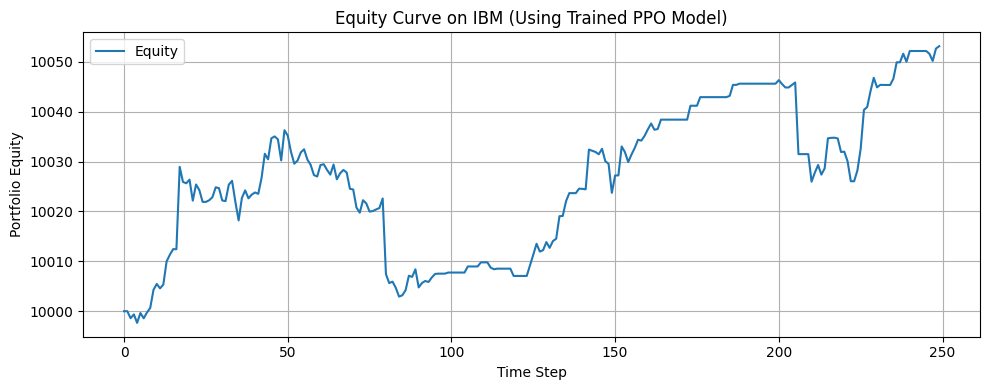

In [3]:
import torch
import matplotlib.pyplot as plt

# === 1. Load the environment with new test data ===
test_env = TradingEnv(data_path="/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/Merged_Data_For_RL/IBM_stock_data_2022-01-01_to_2024-12-31.csv")
state_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.n

# === 2. Initialize the PPO agent and load the trained model ===
agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load("ppo_trading_model_aapl.pt"))
agent.model.eval()
print("✅ Model loaded and ready to test on IBM data.")

# === 3. Run the evaluation loop ===
state = test_env.reset()
done = False
while not done:
    action, _, _ = agent.select_action(state)
    state, reward, done, info = test_env.step(action)
    test_env.render()

# === 4. Compute and print performance ===
roi, sharpe, max_dd = compute_performance_metrics(test_env.equity_history)
print("\n📊 Performance on IBM:")
print(f"ROI: {roi * 100:.2f}%")
print(f"Annualized Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd * 100:.2f}%")

# === 5. Plot equity curve ===
plt.figure(figsize=(10, 4))
plt.plot(test_env.equity_history, label="Equity")
plt.title("Equity Curve on IBM (Using Trained PPO Model)")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Equity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Path to your model and data folder ===
MODEL_PATH = "ppo_trading_model_aapl.pt"
DATA_FOLDER = "/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/InfoTech"

# === Load all CSV files ===
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))

# === Load model once ===
# Use one file to get dimensions
dummy_env = TradingEnv(data_path=csv_files[0])
state_dim = dummy_env.observation_space.shape[0]
action_dim = dummy_env.action_space.n

agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load(MODEL_PATH))
agent.model.eval()
print(f"✅ PPO model loaded from {MODEL_PATH}")

# === Initialize metric storage ===
metrics = []

# === Loop through all CSVs ===
for csv_path in csv_files:
    company = os.path.basename(csv_path).split("_")[0]
    print(f"\n📈 Evaluating {company}...")

    env = TradingEnv(data_path=csv_path)
    state = env.reset()
    done = False

    while not done:
        action, _, _ = agent.select_action(state)
        state, reward, done, info = env.step(action)

    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    metrics.append((company, roi, sharpe, max_dd))

    print(f"ROI: {roi * 100:.2f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd * 100:.2f}%")

# === Compute mean metrics ===
rois = [m[1] for m in metrics]
sharpes = [m[2] for m in metrics]
drawdowns = [m[3] for m in metrics]

print("\n=== 📊 Summary across all companies ===")
print(f"Mean ROI: {np.mean(rois) * 100:.2f}%")
print(f"Mean Sharpe Ratio: {np.mean(sharpes):.2f}")
print(f"Mean Max Drawdown: {np.mean(drawdowns) * 100:.2f}%")


✅ PPO model loaded from ppo_trading_model_aapl.pt

📈 Evaluating CSCO...
ROI: 0.09% | Sharpe: 1.29 | Max DD: 0.04%

📈 Evaluating IBM...
ROI: 0.38% | Sharpe: 0.95 | Max DD: 0.26%

📈 Evaluating MSFT...
ROI: 1.16% | Sharpe: 1.83 | Max DD: 0.32%

📈 Evaluating V...
ROI: 0.52% | Sharpe: 1.57 | Max DD: 0.18%

=== 📊 Summary across all companies ===
Mean ROI: 0.54%
Mean Sharpe Ratio: 1.41
Mean Max Drawdown: 0.20%


In [16]:
# Financials
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Path to your model and data folder ===
MODEL_PATH = "ppo_trading_model_axp.pt"
DATA_FOLDER = "/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/financials"

# === Load all CSV files ===
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))

# === Load model once ===
# Use one file to get dimensions
dummy_env = TradingEnv(data_path=csv_files[0])
state_dim = dummy_env.observation_space.shape[0]
action_dim = dummy_env.action_space.n

agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load(MODEL_PATH))
agent.model.eval()
print(f"✅ PPO model loaded from {MODEL_PATH}")

# === Initialize metric storage ===
metrics = []

# === Loop through all CSVs ===
for csv_path in csv_files:
    company = os.path.basename(csv_path).split("_")[0]
    print(f"\n📈 Evaluating {company}...")

    env = TradingEnv(data_path=csv_path)
    state = env.reset()
    done = False

    while not done:
        action, _, _ = agent.select_action(state)
        state, reward, done, info = env.step(action)

    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    metrics.append((company, roi, sharpe, max_dd))

    print(f"ROI: {roi * 100:.2f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd * 100:.2f}%")

# === Compute mean metrics ===
rois = [m[1] for m in metrics]
sharpes = [m[2] for m in metrics]
drawdowns = [m[3] for m in metrics]

print("\n=== 📊 Summary across all companies ===")
print(f"Mean ROI: {np.mean(rois) * 100:.2f}%")
print(f"Mean Sharpe Ratio: {np.mean(sharpes):.2f}")
print(f"Mean Max Drawdown: {np.mean(drawdowns) * 100:.2f}%")


✅ PPO model loaded from ppo_trading_model_axp.pt

📈 Evaluating GS...
ROI: 2.45% | Sharpe: 2.24 | Max DD: 0.43%

📈 Evaluating JPM...
ROI: 0.89% | Sharpe: 2.16 | Max DD: 0.20%

📈 Evaluating TRV...
ROI: 0.64% | Sharpe: 1.44 | Max DD: 0.39%

=== 📊 Summary across all companies ===
Mean ROI: 1.33%
Mean Sharpe Ratio: 1.95
Mean Max Drawdown: 0.34%


In [15]:
# Industrials
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Path to your model and data folder ===
MODEL_PATH = "ppo_trading_model_ba.pt"
DATA_FOLDER = "/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/industrials"

# === Load all CSV files ===
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))

# === Load model once ===
# Use one file to get dimensions
dummy_env = TradingEnv(data_path=csv_files[0])
state_dim = dummy_env.observation_space.shape[0]
action_dim = dummy_env.action_space.n

agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load(MODEL_PATH))
agent.model.eval()
print(f"✅ PPO model loaded from {MODEL_PATH}")

# === Initialize metric storage ===
metrics = []

# === Loop through all CSVs ===
for csv_path in csv_files:
    company = os.path.basename(csv_path).split("_")[0]
    print(f"\n📈 Evaluating {company}...")

    env = TradingEnv(data_path=csv_path)
    state = env.reset()
    done = False

    while not done:
        action, _, _ = agent.select_action(state)
        state, reward, done, info = env.step(action)

    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    metrics.append((company, roi, sharpe, max_dd))

    print(f"ROI: {roi * 100:.2f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd * 100:.2f}%")

# === Compute mean metrics ===
rois = [m[1] for m in metrics]
sharpes = [m[2] for m in metrics]
drawdowns = [m[3] for m in metrics]

print("\n=== 📊 Summary across all companies ===")
print(f"Mean ROI: {np.mean(rois) * 100:.2f}%")
print(f"Mean Sharpe Ratio: {np.mean(sharpes):.2f}")
print(f"Mean Max Drawdown: {np.mean(drawdowns) * 100:.2f}%")


✅ PPO model loaded from ppo_trading_model_ba.pt

📈 Evaluating CAT...
ROI: 1.35% | Sharpe: 2.05 | Max DD: 0.32%

📈 Evaluating MMM...
ROI: -0.20% | Sharpe: -0.98 | Max DD: 0.27%

📈 Evaluating RTX...
ROI: 0.25% | Sharpe: 1.80 | Max DD: 0.07%

=== 📊 Summary across all companies ===
Mean ROI: 0.47%
Mean Sharpe Ratio: 0.96
Mean Max Drawdown: 0.22%


In [14]:
# Energy
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Path to your model and data folder ===
MODEL_PATH = "ppo_trading_model_cvx.pt"
DATA_FOLDER = "/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/energy"

# === Load all CSV files ===
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))

# === Load model once ===
# Use one file to get dimensions
dummy_env = TradingEnv(data_path=csv_files[0])
state_dim = dummy_env.observation_space.shape[0]
action_dim = dummy_env.action_space.n

agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load(MODEL_PATH))
agent.model.eval()
print(f"✅ PPO model loaded from {MODEL_PATH}")

# === Initialize metric storage ===
metrics = []

# === Loop through all CSVs ===
for csv_path in csv_files:
    company = os.path.basename(csv_path).split("_")[0]
    print(f"\n📈 Evaluating {company}...")

    env = TradingEnv(data_path=csv_path)
    state = env.reset()
    done = False

    while not done:
        action, _, _ = agent.select_action(state)
        state, reward, done, info = env.step(action)

    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    metrics.append((company, roi, sharpe, max_dd))

    print(f"ROI: {roi * 100:.2f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd * 100:.2f}%")

# === Compute mean metrics ===
rois = [m[1] for m in metrics]
sharpes = [m[2] for m in metrics]
drawdowns = [m[3] for m in metrics]

print("\n=== 📊 Summary across all companies ===")
print(f"Mean ROI: {np.mean(rois) * 100:.2f}%")
print(f"Mean Sharpe Ratio: {np.mean(sharpes):.2f}")
print(f"Mean Max Drawdown: {np.mean(drawdowns) * 100:.2f}%")


✅ PPO model loaded from ppo_trading_model_cvx.pt

📈 Evaluating XOM...
ROI: 0.15% | Sharpe: 0.86 | Max DD: 0.11%

=== 📊 Summary across all companies ===
Mean ROI: 0.15%
Mean Sharpe Ratio: 0.86
Mean Max Drawdown: 0.11%


In [18]:
# Consumer
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Path to your model and data folder ===
MODEL_PATH = "ppo_trading_model_hd.pt"
DATA_FOLDER = "/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/consumer"

# === Load all CSV files ===
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))

# === Load model once ===
# Use one file to get dimensions
dummy_env = TradingEnv(data_path=csv_files[0])
state_dim = dummy_env.observation_space.shape[0]
action_dim = dummy_env.action_space.n

agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load(MODEL_PATH))
agent.model.eval()
print(f"✅ PPO model loaded from {MODEL_PATH}")

# === Initialize metric storage ===
metrics = []

# === Loop through all CSVs ===
for csv_path in csv_files:
    company = os.path.basename(csv_path).split("_")[0]
    print(f"\n📈 Evaluating {company}...")

    env = TradingEnv(data_path=csv_path)
    state = env.reset()
    done = False

    while not done:
        action, _, _ = agent.select_action(state)
        state, reward, done, info = env.step(action)

    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    metrics.append((company, roi, sharpe, max_dd))

    print(f"ROI: {roi * 100:.2f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd * 100:.2f}%")

# === Compute mean metrics ===
rois = [m[1] for m in metrics]
sharpes = [m[2] for m in metrics]
drawdowns = [m[3] for m in metrics]

print("\n=== 📊 Summary across all companies ===")
print(f"Mean ROI: {np.mean(rois) * 100:.2f}%")
print(f"Mean Sharpe Ratio: {np.mean(sharpes):.2f}")
print(f"Mean Max Drawdown: {np.mean(drawdowns) * 100:.2f}%")


✅ PPO model loaded from ppo_trading_model_hd.pt

📈 Evaluating DIS...
ROI: 0.11% | Sharpe: 0.59 | Max DD: 0.20%

📈 Evaluating MCD...
ROI: 0.03% | Sharpe: 0.09 | Max DD: 0.36%

📈 Evaluating NKE...
ROI: 0.12% | Sharpe: 0.79 | Max DD: 0.09%

=== 📊 Summary across all companies ===
Mean ROI: 0.08%
Mean Sharpe Ratio: 0.49
Mean Max Drawdown: 0.22%


In [29]:
# Comsumer Staples
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Path to your model and data folder ===
MODEL_PATH = "ppo_trading_model_ko.pt"
DATA_FOLDER = "/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/consumer_staples"

# === Load all CSV files ===
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))

# === Load model once ===
# Use one file to get dimensions
dummy_env = TradingEnv(data_path=csv_files[0])
state_dim = dummy_env.observation_space.shape[0]
action_dim = dummy_env.action_space.n

agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load(MODEL_PATH))
agent.model.eval()
print(f"✅ PPO model loaded from {MODEL_PATH}")

# === Initialize metric storage ===
metrics = []

# === Loop through all CSVs ===
for csv_path in csv_files:
    company = os.path.basename(csv_path).split("_")[0]
    print(f"\n📈 Evaluating {company}...")

    env = TradingEnv(data_path=csv_path)
    state = env.reset()
    done = False

    while not done:
        action, _, _ = agent.select_action(state)
        state, reward, done, info = env.step(action)

    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    metrics.append((company, roi, sharpe, max_dd))

    print(f"ROI: {roi * 100:.2f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd * 100:.2f}%")

# === Compute mean metrics ===
rois = [m[1] for m in metrics]
sharpes = [m[2] for m in metrics]
drawdowns = [m[3] for m in metrics]

print("\n=== 📊 Summary across all companies ===")
print(f"Mean ROI: {np.mean(rois) * 100:.2f}%")
print(f"Mean Sharpe Ratio: {np.mean(sharpes):.2f}")
print(f"Mean Max Drawdown: {np.mean(drawdowns) * 100:.2f}%")


✅ PPO model loaded from ppo_trading_model_ko.pt

📈 Evaluating PG...
ROI: 0.14% | Sharpe: 0.91 | Max DD: 0.09%

📈 Evaluating WMT...
ROI: 0.17% | Sharpe: 1.78 | Max DD: 0.05%

=== 📊 Summary across all companies ===
Mean ROI: 0.16%
Mean Sharpe Ratio: 1.34
Mean Max Drawdown: 0.07%


In [24]:
# Healthcare
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Path to your model and data folder ===
MODEL_PATH = "ppo_trading_model_jnj.pt"
DATA_FOLDER = "/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/healthcare"

# === Load all CSV files ===
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))

# === Load model once ===
# Use one file to get dimensions
dummy_env = TradingEnv(data_path=csv_files[0])
state_dim = dummy_env.observation_space.shape[0]
action_dim = dummy_env.action_space.n

agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load(MODEL_PATH))
agent.model.eval()
print(f"✅ PPO model loaded from {MODEL_PATH}")

# === Initialize metric storage ===
metrics = []

# === Loop through all CSVs ===
for csv_path in csv_files:
    company = os.path.basename(csv_path).split("_")[0]
    print(f"\n📈 Evaluating {company}...")

    env = TradingEnv(data_path=csv_path)
    state = env.reset()
    done = False

    while not done:
        action, _, _ = agent.select_action(state)
        state, reward, done, info = env.step(action)

    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    metrics.append((company, roi, sharpe, max_dd))

    print(f"ROI: {roi * 100:.2f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd * 100:.2f}%")

# === Compute mean metrics ===
rois = [m[1] for m in metrics]
sharpes = [m[2] for m in metrics]
drawdowns = [m[3] for m in metrics]

print("\n=== 📊 Summary across all companies ===")
print(f"Mean ROI: {np.mean(rois) * 100:.2f}%")
print(f"Mean Sharpe Ratio: {np.mean(sharpes):.2f}")
print(f"Mean Max Drawdown: {np.mean(drawdowns) * 100:.2f}%")


✅ PPO model loaded from ppo_trading_model_jnj.pt

📈 Evaluating MRK...
ROI: -0.00% | Sharpe: -0.00 | Max DD: 0.18%

📈 Evaluating PFE...
ROI: -0.01% | Sharpe: -0.29 | Max DD: 0.04%

📈 Evaluating UNH...
ROI: 1.32% | Sharpe: 1.63 | Max DD: 0.31%

=== 📊 Summary across all companies ===
Mean ROI: 0.44%
Mean Sharpe Ratio: 0.45
Mean Max Drawdown: 0.18%


In [31]:
# Communication Services
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Path to your model and data folder ===
MODEL_PATH = "ppo_trading_model_vz.pt"
DATA_FOLDER = "/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/communications"

# === Load all CSV files ===
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))

# === Load model once ===
# Use one file to get dimensions
dummy_env = TradingEnv(data_path=csv_files[0])
state_dim = dummy_env.observation_space.shape[0]
action_dim = dummy_env.action_space.n

agent = PPOAgent(input_dim=state_dim, action_dim=action_dim)
agent.model.load_state_dict(torch.load(MODEL_PATH))
agent.model.eval()
print(f"✅ PPO model loaded from {MODEL_PATH}")

# === Initialize metric storage ===
metrics = []

# === Loop through all CSVs ===
for csv_path in csv_files:
    company = os.path.basename(csv_path).split("_")[0]
    print(f"\n📈 Evaluating {company}...")

    env = TradingEnv(data_path=csv_path)
    state = env.reset()
    done = False

    while not done:
        action, _, _ = agent.select_action(state)
        state, reward, done, info = env.step(action)

    roi, sharpe, max_dd = compute_performance_metrics(env.equity_history)
    metrics.append((company, roi, sharpe, max_dd))

    print(f"ROI: {roi * 100:.2f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd * 100:.2f}%")

# === Compute mean metrics ===
rois = [m[1] for m in metrics]
sharpes = [m[2] for m in metrics]
drawdowns = [m[3] for m in metrics]

print("\n=== 📊 Summary across all companies ===")
print(f"Mean ROI: {np.mean(rois) * 100:.2f}%")
print(f"Mean Sharpe Ratio: {np.mean(sharpes):.2f}")
print(f"Mean Max Drawdown: {np.mean(drawdowns) * 100:.2f}%")


✅ PPO model loaded from ppo_trading_model_vz.pt

📈 Evaluating DIS...
ROI: 0.34% | Sharpe: 1.72 | Max DD: 0.14%

=== 📊 Summary across all companies ===
Mean ROI: 0.34%
Mean Sharpe Ratio: 1.72
Mean Max Drawdown: 0.14%
